# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import os
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mne
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster

In [2]:
# packageroot = Path('../../').resolve()
packageroot = Path('/home/dongjp/source-code/PyEEG').resolve()
print(packageroot)
sys.path.append(str(packageroot))

from pythoneeg import core
from pythoneeg import visualization
from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

/home/dongjp/source-code/PyEEG


/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'set_temp_directory', 'get_temp_directory', 'parse_path_to_animalday', 'parse_path_to_genotype', 'parse_path_to_animal', 'parse_path_to_day', 'parse_chname_to_abbrev', 'nanaverage', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer']


In [3]:
core.set_temp_directory('/scr1/users/dongjp')

In [4]:
tmpmet = core.DDFBinaryMetadata(r"/mnt/isilon/marsh_single_unit/PythonEEG Data Bins/A5 WT 12_12-2023/Cage 1 A5 -1_Meta.csv")
print(tmpmet.dt_end.ctime())
display(tmpmet.channel_names)

Tue Dec 12 12:57:00 2023


['Intan Input (1)/PortB L Aud Ctx',
 'Intan Input (1)/PortB L Vis Ctx',
 'Intan Input (1)/PortB L Hipp',
 'Intan Input (1)/PortB L Barrel',
 'Intan Input (1)/PortB L Motor',
 'Intan Input (1)/PortB R Motor',
 'Intan Input (1)/PortB R Barrel',
 'Intan Input (1)/PortB R Hipp',
 'Intan Input (1)/PortB R Vis Ctx',
 'Intan Input (1)/PortB R Aud Ctx']

In [5]:
data_folder = Path('./test-data').resolve()
lrec = core.LongRecordingOrganizer(base_folder_path= data_folder / 'A10 KO 12_13_2023',
                                    truncate=3)
lrec.convert_colbins_to_rowbins(overwrite=False)
lrec.convert_rowbins_to_rec()

/home/dongjp/source-code/PyEEG/pythoneeg/core/core.py:152: UserWarning: truncate = True. Only the first 3 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")


In [6]:
Path('./test-wars/A5').resolve()

PosixPath('/home/dongjp/source-code/PyEEG/notebooks/tests/test-wars/A5')

In [7]:
cluster_window = SLURMCluster(
        cores=8,
        processes=1, # Threaded parallelization works best for WAR
        memory='20GB',
        walltime='12:00:00',
        interface=None,
        scheduler_options={'interface': 'eth1'},
        job_extra_directives=['--output=/dev/null',
                             '--error=/dev/null']
    )
cluster_window.scale(jobs=15)
display(cluster_window)
cluster_window.wait_for_workers(15)

Dashboard: http://172.16.7.147:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.7.147:39081,Workers: 0
Dashboard: http://172.16.7.147:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [ ]:
cluster_spike = SLURMCluster(
        cores=1,
        memory='10GB',
        processes=1,
        walltime='12:00:00',
        interface=None,
        scheduler_options={'interface': 'eth1'},
        job_extra_directives=['--output=/dev/null',
                             '--error=/dev/null']
    )
cluster_spike.scale(12)
display(cluster_spike)
cluster_spike.wait_for_workers(12)

/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42217 instead
  warnings.warn(


Dashboard: http://172.16.7.147:42217/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.7.147:45693,Workers: 0
Dashboard: http://172.16.7.147:42217/status,Total threads: 0
Started: Just now,Total memory: 0 B


: 

In [ ]:
# %%script true
# animal_ids = ['A5', 'A10', 'F22', 'G25', 'G26', 'N21', 'N22', 'N23', 'N24', 'N25']
# animal_ids = ['A5']
# animal_ids = ['A10', 'F22']
animal_ids = ['F22']
# animal_ids = ['G25']
# base_folder = Path('./test-data').resolve()
base_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True)
    ao.convert_colbins_to_rowbins(overwrite=False)
    # ao.convert_rowbins_to_rec() # parallelization breaks if not enough memory

    with Client(cluster_window) as client:
        client.upload_file(str(packageroot / 'pythoneeg.zip'))
        display(client)
        print("running war")
        ao.convert_rowbins_to_rec(multiprocess_mode='dask') # paralleization breaks if not enough memory
        war = ao.compute_windowed_analysis(['all'], multiprocess_mode='dask')
        # war.save_pickle_and_json(Path(f'./test-wars-full/{animal_id}').resolve())

    with Client(cluster_spike) as client:
        client.upload_file(str(packageroot / 'pythoneeg.zip'))
        display(client)
        print("running sars")
        sars = ao.compute_spike_analysis(multiprocess_mode='dask')
    raws = []
    for sar in sars:
        raws.append(sar.convert_to_mne())

Converting column bins to row bins: 100%|██████████| 4/4 [00:00<00:00, 47.58it/s]


<Client: 'tcp://172.16.7.147:39081' processes=15 threads=120, memory=279.45 GiB>

Converting row bins to recs: 100%|██████████| 4/4 [03:00<00:00, 45.03s/it]


running war


Converting row bins to recs: 100%|██████████| 4/4 [01:57<00:00, 29.27s/it]
/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 14.12 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 13.45 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/dongjp/source-code/PyEEG/pythoneeg/visualization/results.

Channel names: 	['Intan Input (1)/PortD D-009', 'Intan Input (1)/PortD D-010', 'Intan Input (1)/PortD D-012', 'Intan Input (1)/PortD D-014', 'Intan Input (1)/PortD D-015', 'Intan Input (1)/PortD D-016', 'Intan Input (1)/PortD D-017', 'Intan Input (1)/PortD D-019', 'Intan Input (1)/PortD D-021', 'Intan Input (1)/PortD D-022']
Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


<Client: 'tcp://172.16.7.147:45693' processes=12 threads=12, memory=111.72 GiB>

running sars


In [16]:
nspike_sars = war.read_sars_spikes(sars, inplace=False)['nspikes']
nspike_mnes = war.read_mnes_spikes(raws, inplace=False)['nspikes']

# Check if nspike_sars and nspike_mnes are equal
nspike_sars = np.array(nspike_sars.tolist())
nspike_mnes = np.array(nspike_mnes.tolist())
np.array_equal(nspike_sars, nspike_mnes)

2025-04-07 20:41:39,782 - DEBUG - Animal days: dict_keys(['F22 KO Dec-12-2023'])
Used Annotations descriptions: [np.str_('Intan Input (1)/PortD D-009'), np.str_('Intan Input (1)/PortD D-010'), np.str_('Intan Input (1)/PortD D-014'), np.str_('Intan Input (1)/PortD D-015'), np.str_('Intan Input (1)/PortD D-016'), np.str_('Intan Input (1)/PortD D-017'), np.str_('Intan Input (1)/PortD D-019')]
2025-04-07 20:41:39,874 - DEBUG - Events: [[   194      0      1]
 [   202      0      1]
 [   221      0      1]
 [   254      0      1]
 [   293      0      7]
 [   301      0      1]
 [   312      0      1]
 [   326      0      7]
 [   349      0      1]
 [   364      0      1]
 [   382      0      7]
 [   390      0      1]
 [   398      0      7]
 [   412      0      1]
 [   419      0      7]
 [   422      0      7]
 [   447      0      1]
 [   449      0      7]
 [   464      0      7]
 [   470      0      1]
 [   481      0      1]
 [   484      0      7]
 [   505      0      1]
 [   515     

True

## Test WAR

In [14]:
# Set up logger with detailed formatting
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG, stream=sys.stdout, force=True)
logger = logging.getLogger()


In [11]:
war = visualization.WindowAnalysisResult.load_pickle_and_json(Path('./test-wars/F22').resolve())

2025-04-04 20:58:56,543 - WARNING - Intan Input (1)/PortD D-009 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:56,544 - WARNING - Intan Input (1)/PortD D-010 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:56,546 - WARNING - Intan Input (1)/PortD D-012 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:56,547 - WARNING - Intan Input (1)/PortD D-014 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:56,550 - WARNING - Intan Input (1)/PortD D-015 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:56,560 - WARNING - Intan Input (1)/PortD D-016 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:56,567 - WARNING - Intan Input (1)/PortD D-017 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:56,568 - WARNING - Intan

In [12]:
war.get_result(['all'], allow_missing=True).head(3)

,index,animalday,animal,day,genotype,duration,endfile,timestamp,isday,rms,ampvar,psd,psdtotal,psdband,psdfrac,psdslope,cohere,pcorr
0,0,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:13.560,True,"[324.54126, 123.114975, 89.73853, 199.99457, 3...","[98233.31, 14860.118, 7970.6294, 37275.664, 15...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[2991.1634385554166, 9655.58377513804, 4896.79...","{'delta': [2371.695324738739, 3296.14610609939...","{'delta': [0.7929006132423677, 0.3413720167377...","[[-1.6266363283601732, 3.0386960730587895], [-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:17.560,True,"[33.98209, 98.85394, 73.50655, 72.370285, 407....","[1154.7565, 9768.589, 5399.9756, 5234.582, 165...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[617.6503225177026, 8764.378583594078, 4536.85...","{'delta': [190.0428130962193, 1800.43295303487...","{'delta': [0.3076867382203503, 0.2054261960346...","[[-1.2730235496671296, 2.4032617509449405], [-...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2,F22 KO Dec-12-2023,F22,2023-12-12,KO,4.0,None,2023-12-12 12:49:21.560,True,"[39.47056, 100.14916, 70.84106, 86.55565, 620....","[1557.7701, 10023.703, 5018.388, 7481.0225, 38...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,...","[808.7404621241202, 7759.685803861311, 3899.87...","{'delta': [306.9726448654066, 2821.06366983401...","{'delta': [0.3795687977069391, 0.3635538527127...","[[-1.4760446379997991, 2.664199600531952], [-1...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


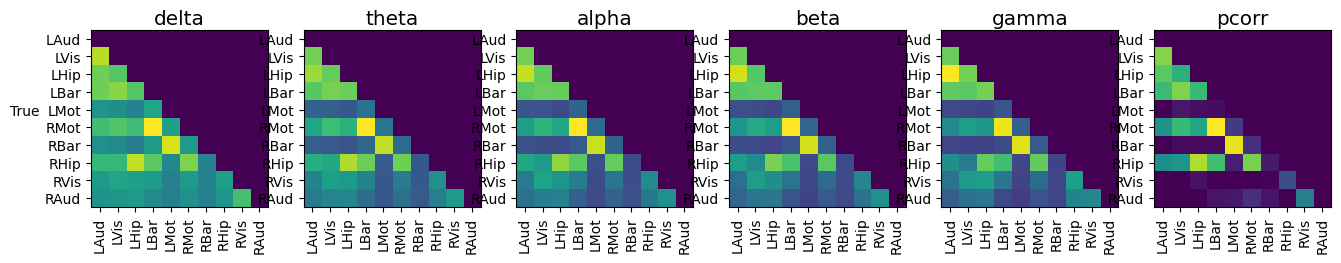

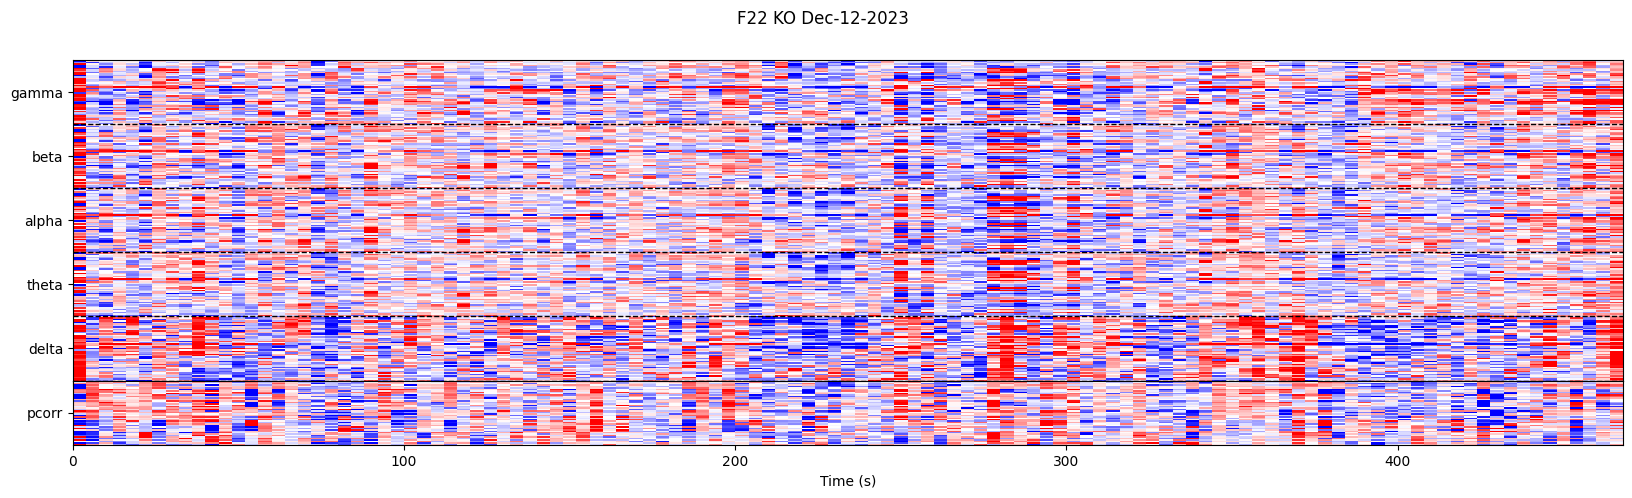

/home/dongjp/source-code/PyEEG/pythoneeg/visualization/plotting/animal.py:326: RuntimeWarning: divide by zero encountered in log10
  ax[0, i].plot(freqs, 10**(b + m * np.log10(freqs)), c=f'C{j}', alpha=0.75)


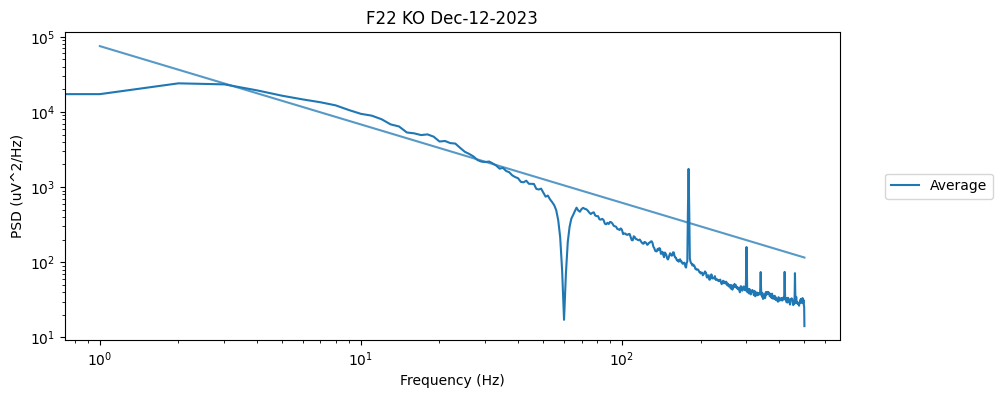

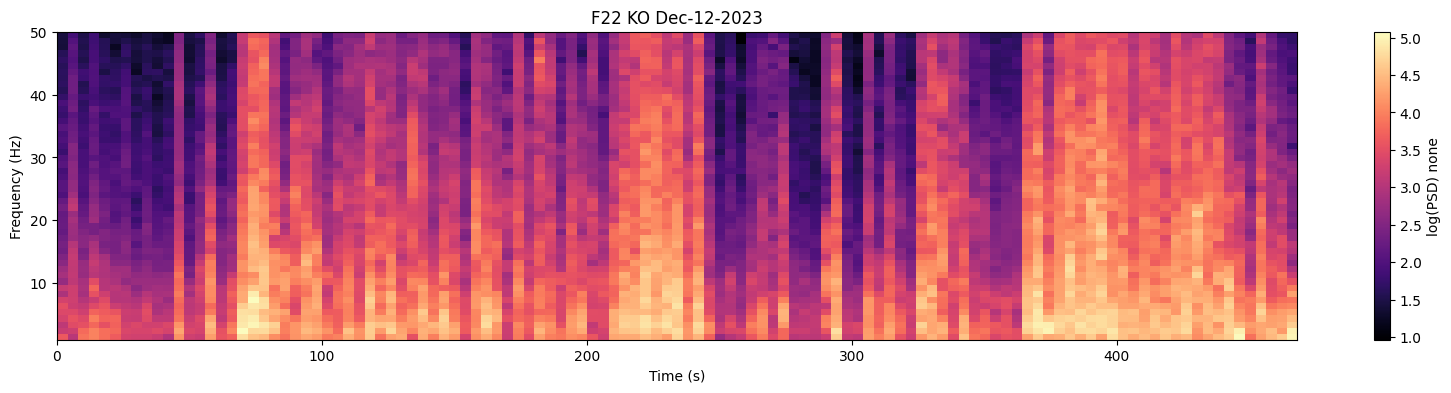

In [13]:
logger.setLevel(logging.WARNING)
ap = visualization.AnimalPlotter(war)
ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
# ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')

ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
ap.plot_psd_histogram(figsize=(10, 4), avg_channels=True, plot_type='loglog')
ap.plot_psd_spectrogram(figsize=(20, 4), mode='none')

In [14]:
logger.setLevel(logging.DEBUG)
wars = []
animal_ids = ['A10', 'F22']
for animal_id in animal_ids:
    war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
    # logging.critical(war.result.iloc[0]['pcorr'])
    # war = war.filter_all()
    # logging.critical(war.result.iloc[0]['pcorr'])
    wars.append(war)
ep = visualization.ExperimentPlotter(wars)


2025-04-04 20:58:58,894 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:58,895 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:58,896 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:58,897 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:58,898 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:58,899 - WARNING - Intan Input (1)/PortC C-016 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:58,900 - WARNING - Intan Input (1)/PortC C-017 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:58,900 - WARNING - Intan

In [15]:
for feat in constants.LINEAR_FEATURE:
    logging.info(f'pulling {feat}')
    ep._pull_timeseries_dataframe(feat, ['genotype','animalday'])

2025-04-04 20:58:58,972 - INFO - pulling rms
2025-04-04 20:58:58,986 - DEBUG - groups: [('KO', 'A10 KO Dec-13-2023'), ('KO', 'F22 KO Dec-12-2023')]
2025-04-04 20:58:58,987 - DEBUG - vals.shape: (31, 10)
2025-04-04 20:58:58,995 - DEBUG - vals.shape: (117, 10)
2025-04-04 20:58:59,021 - INFO - pulling ampvar
2025-04-04 20:58:59,025 - DEBUG - groups: [('KO', 'A10 KO Dec-13-2023'), ('KO', 'F22 KO Dec-12-2023')]
2025-04-04 20:58:59,026 - DEBUG - vals.shape: (31, 10)
2025-04-04 20:58:59,029 - DEBUG - vals.shape: (117, 10)
2025-04-04 20:58:59,048 - INFO - pulling psdtotal
2025-04-04 20:58:59,065 - DEBUG - groups: [('KO', 'A10 KO Dec-13-2023'), ('KO', 'F22 KO Dec-12-2023')]
2025-04-04 20:58:59,068 - DEBUG - vals.shape: (31, 10)
2025-04-04 20:58:59,071 - DEBUG - vals.shape: (117, 10)
2025-04-04 20:58:59,098 - INFO - pulling psdslope
2025-04-04 20:58:59,102 - DEBUG - groups: [('KO', 'A10 KO Dec-13-2023'), ('KO', 'F22 KO Dec-12-2023')]
2025-04-04 20:58:59,104 - DEBUG - vals.shape: (31, 10, 2)
2025

In [16]:
logger.setLevel(logging.DEBUG)
wars = []
# animal_ids = ['A10', 'F22']
animal_ids = ['A10']
for animal_id in animal_ids:
    # war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
    war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
    
    # war = war.filter_all()
    
    wars.append(war)
ep = visualization.ExperimentPlotter(wars)


2025-04-04 20:58:59,163 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:59,164 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:59,165 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:59,165 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:59,165 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:59,166 - WARNING - Intan Input (1)/PortC C-016 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:59,169 - WARNING - Intan Input (1)/PortC C-017 does not match name aliases. Assuming alias from number in channel name.
2025-04-04 20:58:59,170 - WARNING - Intan

In [17]:
# df = ep._pull_timeseries_dataframe('rms', ['genotype','animal'])
# rms = df[(df['animal'] == 'F22') & (df['channel'] == 'LAud')]['rms'].dropna()
# rms = df[(df['animal'] == 'A10') & (df['channel'] == 'LAud')]['rms'].dropna()

df2 = ep._pull_timeseries_dataframe('rms', ['genotype','animal'], collapse_channels=True)

2025-04-04 20:58:59,213 - DEBUG - groups: [('KO', 'A10')]
2025-04-04 20:58:59,215 - DEBUG - vals.shape: (31,)


2025-04-04 20:58:59,243 - DEBUG - groups: ['A10']
2025-04-04 20:58:59,243 - DEBUG - vals.shape: (31, 10)


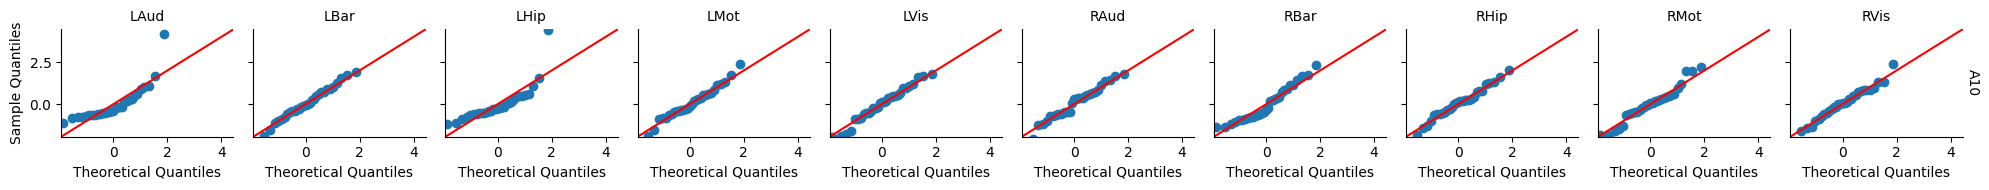

In [18]:
# g = ep.plot_qqplot('psdband', ['animal'], row='channel', col='band', height=2, log=True)
# plt.show()
g = ep.plot_qqplot('rms', ['animal'], row='animal', col='channel', height=2, log=True)
plt.show()
# g = ep.plot_qqplot('psdband', ['animal'], row='animal', col='channel', height=3, log=True)
# plt.show()

## Test SAR/MNE

2025-04-04 20:59:01,302 - DEBUG - groups: ['A10']
2025-04-04 20:59:01,303 - DEBUG - vals.shape: (31, 10, 5)


/home/dongjp/source-code/PyEEG/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


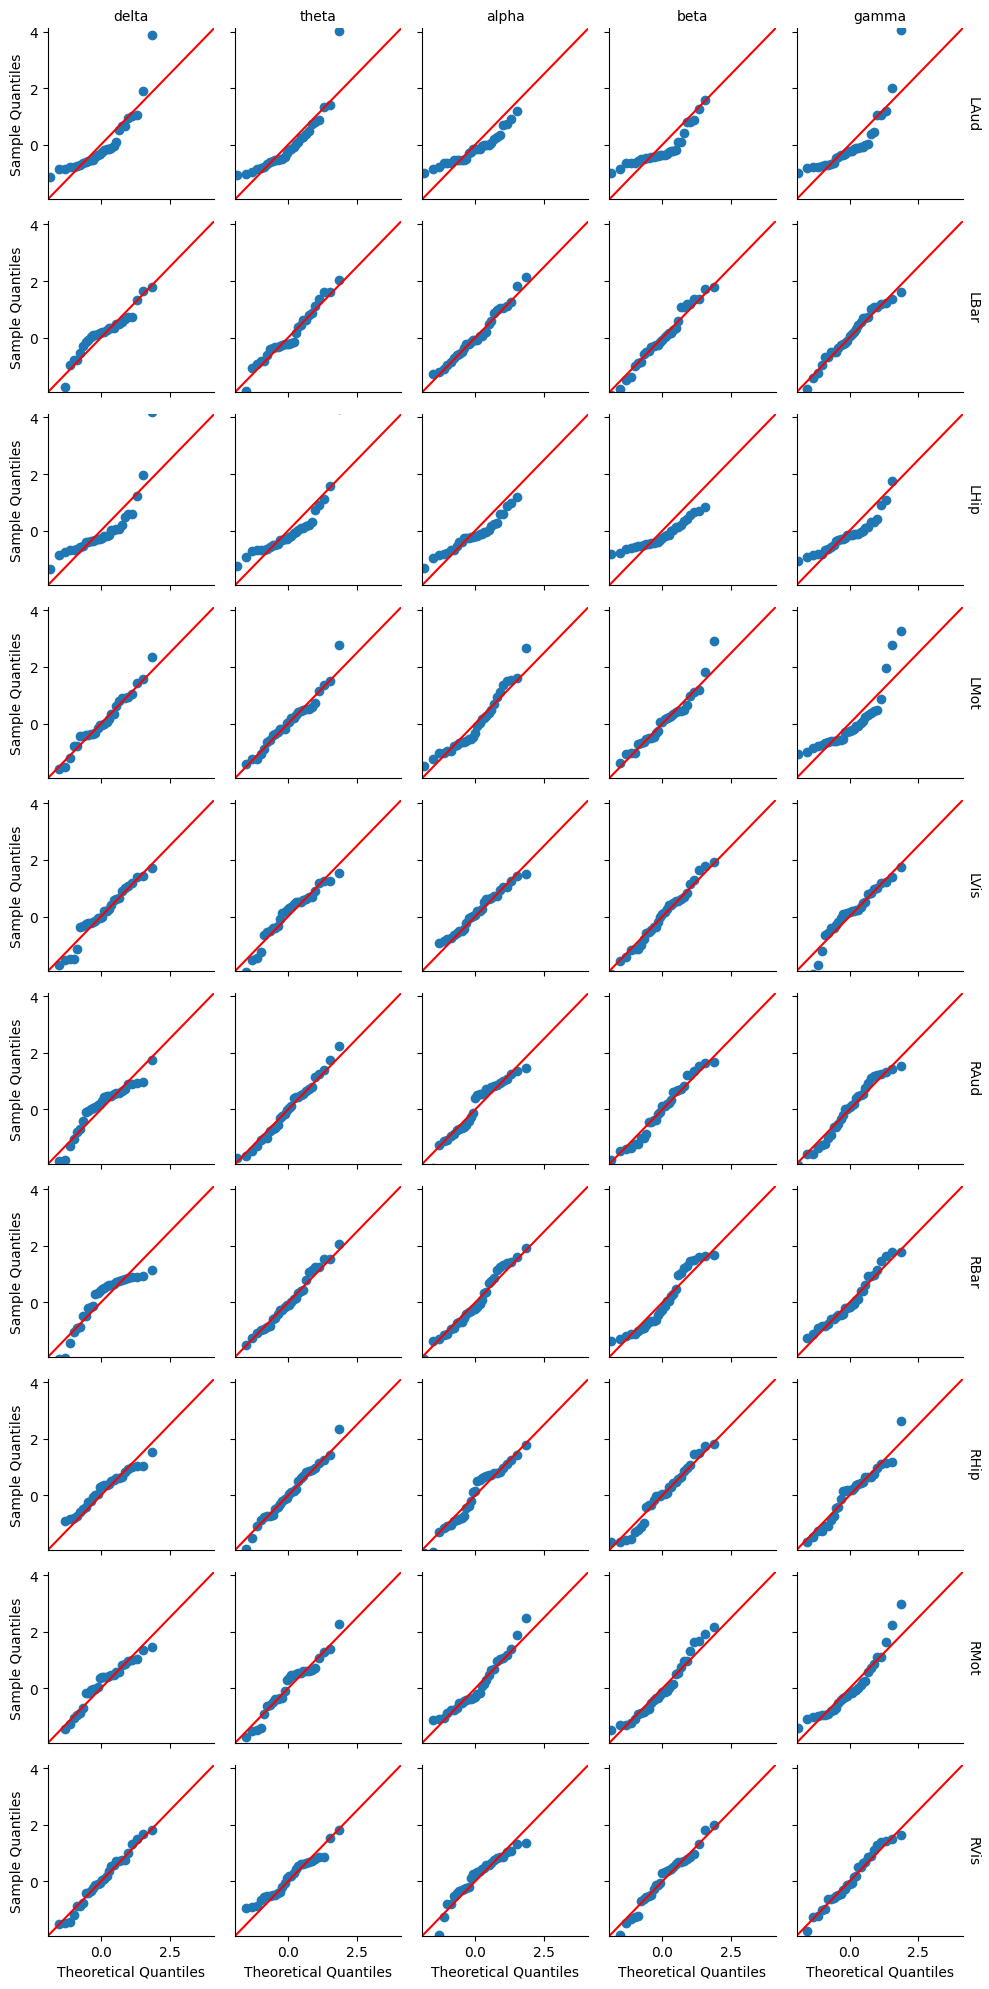

In [19]:
g = ep.plot_qqplot('psdband', ['animal'], row='channel', col='band', height=2, log=True)
plt.show()
# g = ep.plot_qqplot('psdband', ['animal'], row='animal', col='channel', height=3, log=True)
# plt.show()

## Test SAR/MNE

In [20]:
logger.setLevel(logging.DEBUG)

In [21]:
for e in sar:
    e.convert_to_mne(chunk_len=1440)
    # e.save_fif_and_json(Path(f'./test-mnes/{e.animal_day}').resolve(), overwrite=True)

2025-04-04 20:59:10,946 - DEBUG - Converting channel 0 of 10
2025-04-04 20:59:10,949 - DEBUG - Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 466,440 samples 
                       466.44s (7.77 minutes) - float32 dtype - 1.78 MiB
2025-04-04 20:59:10,983 - DEBUG - Converting channel 1 of 10
2025-04-04 20:59:10,984 - DEBUG - Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 466,440 samples 
                       466.44s (7.77 minutes) - float32 dtype - 1.78 MiB
2025-04-04 20:59:11,017 - DEBUG - Converting channel 2 of 10
2025-04-04 20:59:11,017 - DEBUG - Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 466,440 samples 
                       466.44s (7.77 minutes) - float32 dtype - 1.78 MiB
2025-04-04 20:59:11,038 - DEBUG - Converting channel 3 of 10
2025-04-04 20:59:11,039 - DEBUG - Recording info: ChannelSliceRecording: 1 channels - 1000.0Hz - 1 segments - 466,440 samples 
                       466.44

In [22]:
reconstruct_sas = visualization.SpikeAnalysisResult.load_fif_and_json('./test-mnes/A5 WT Dec-12-2023')
mne_obj = reconstruct_sas.result_mne

Opening raw data file test-mnes/A5 WT Dec-12-2023/A5-WT-A5 WT Dec-12-2023-raw.fif...
    Reading extended channel information
Isotrak not found
    Range : 0 ... 40067758 =      0.000 ... 40067.758 secs
Ready.
2025-04-04 20:59:21,392 - INFO - Channel names: 	['Intan Input (1)/PortB L Aud Ctx', 'Intan Input (1)/PortB L Vis Ctx', 'Intan Input (1)/PortB L Hipp', 'Intan Input (1)/PortB L Barrel', 'Intan Input (1)/PortB L Motor', 'Intan Input (1)/PortB R Motor', 'Intan Input (1)/PortB R Barrel', 'Intan Input (1)/PortB R Hipp', 'Intan Input (1)/PortB R Vis Ctx', 'Intan Input (1)/PortB R Aud Ctx']
2025-04-04 20:59:21,396 - INFO - Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]


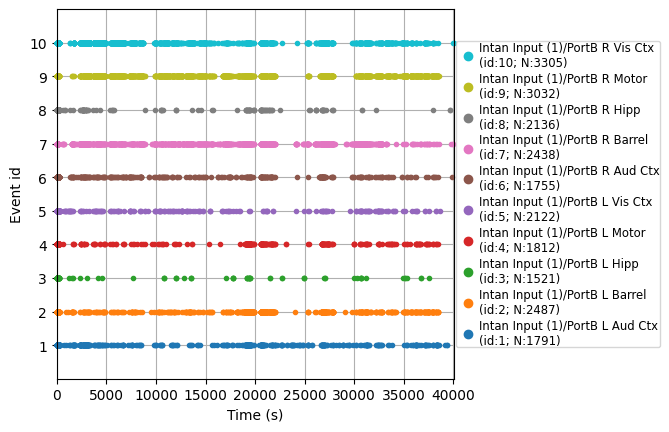

In [23]:
logger.setLevel(logging.WARNING)
events, event_id = mne.events_from_annotations(raw=mne_obj)
fig = mne.viz.plot_events(events, sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=event_id)